# 1. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import MDAnalysis as mda
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['legend.frameon'] = False
mpl.font_manager.findSystemFonts(fontpaths="/home/marco/.local/share/fonts", fontext="ttf")
mpl.rcParams['font.family'] = 'Oswald'

palette = ['royalblue', 'darkorange','forestgreen']

/home/marco/anaconda3/envs/MD/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


# 2. Basic analysis

## RMSD

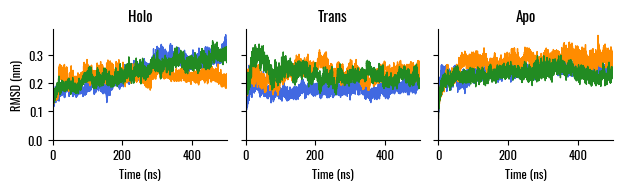

In [2]:
# Load data
time = np.loadtxt('../02-analysis/rmsd_apo_rep1.xvg', usecols=0,comments=['#','@'])
rmsds_holo = np.column_stack((np.loadtxt('../02-analysis/rmsd_holo_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_holo_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_holo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsds_apo = np.column_stack((np.loadtxt('../02-analysis/rmsd_apo_rep1.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsd_apo_rep2.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsd_apo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsds_tran = np.column_stack((np.loadtxt('../02-analysis/rmsd_trans_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_trans_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsd_trans_rep3.xvg', usecols=1,comments=['#','@'])))

fig,ax = plt.subplots(1,3,figsize=(16/2.54,5/2.54),sharey=True,sharex=True)
for i,r in enumerate([rmsds_holo,rmsds_tran,rmsds_apo]):
    ax[i].plot(time,r[:,0],color=palette[0],label='Rep 1')
    ax[i].plot(time,r[:,1],color=palette[1],label='Rep 2')
    ax[i].plot(time,r[:,2],color=palette[2],label='Rep 3')
    ax[i].set_xlabel('Time (ns)')
    ax[i].set_xlim(0,500)
    ax[i].set_ylim(bottom=0)

ax[0].set_ylabel('RMSD (nm)')
ax[0].set_title('Holo'); ax[1].set_title('Trans'); ax[2].set_title('Apo')
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/RMSD.png',dpi=600,facecolor='white')

## RMSF

In [3]:
def add_helices(ax,botlim=0,w=0.02):
    from matplotlib.patches import Rectangle
    ax.add_patch(Rectangle((3,botlim),36,w,  fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((3,botlim),299,w, fill=True,lw=0,color='darkgrey',zorder=-1))
    ax.add_patch(Rectangle((42,botlim),30,w, fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((77,botlim),35,w, fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((124,botlim),30,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((173,botlim),40,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((218,botlim),36,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((258,botlim),24,w,fill=True,lw=0,color='k',zorder=0))
    ax.add_patch(Rectangle((283,botlim),18,w,fill=True,lw=0,color='k',zorder=0))
    ax.text(20, botlim+w+0.005,"TM1",fontsize=9, ha='center')
    ax.text((3+36+42)/2,botlim+w+0.005,"ICL1",fontsize=9, ha='center',color='darkgrey')
    ax.text(57, botlim+w+0.005,"TM2",fontsize=9, ha='center')
    ax.text((42+30+77)/2, botlim+w+0.005,"ECL1",fontsize=9, ha='center',color='darkgrey')
    ax.text(95, botlim+w+0.005,"TM3",fontsize=9, ha='center')
    ax.text((77+35+124)/2,botlim+w+0.005,"ECL2",fontsize=9, ha='center',color='darkgrey')
    ax.text(139,botlim+w+0.005,"TM4",fontsize=9, ha='center')
    ax.text((124+30+173)/2,botlim+w+0.005,"ECL2",fontsize=9, ha='center',color='darkgrey')
    ax.text(193,botlim+w+0.005,"TM5",fontsize=9, ha='center')
    ax.text((173+40+218)/2,botlim+w+0.005,"ICL3",fontsize=9, ha='center',color='darkgrey')
    ax.text(236,botlim+w+0.005,"TM6",fontsize=9, ha='center')
    ax.text((218+36+258)/2,botlim+w+0.005,"ECL3",fontsize=9, ha='center',color='darkgrey')
    ax.text(270,botlim+w+0.005,"TM7",fontsize=9, ha='center')
    ax.text(292,botlim+w+0.005,"H8", fontsize=9, ha='center')

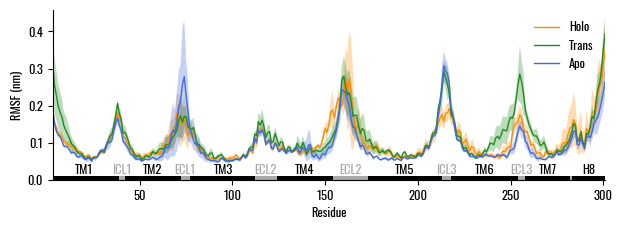

In [59]:
# load data
residues = np.loadtxt('../02-analysis/rmsf_apo_rep1.xvg', usecols=0,comments=['#','@'])

rmsfs_holo = np.column_stack((np.loadtxt('../02-analysis/rmsf_holo_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_holo_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_holo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsfs_apo = np.column_stack((np.loadtxt('../02-analysis/rmsf_apo_rep1.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsf_apo_rep2.xvg', usecols=1,comments=['#','@']),
                             np.loadtxt('../02-analysis/rmsf_apo_rep3.xvg', usecols=1,comments=['#','@'])))

rmsfs_tran = np.column_stack((np.loadtxt('../02-analysis/rmsf_trans_rep1.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_trans_rep2.xvg', usecols=1,comments=['#','@']),
                              np.loadtxt('../02-analysis/rmsf_trans_rep3.xvg', usecols=1,comments=['#','@'])))

fig,ax = plt.subplots(1,1,figsize=(16/2.54,6/2.54))
ax.plot(residues,rmsfs_holo.mean(axis=1),color=palette[1],label='Holo')
ax.plot(residues,rmsfs_tran.mean(axis=1),color=palette[2],label='Trans')
ax.plot(residues,rmsfs_apo.mean(axis=1),color=palette[0],label='Apo')

ax.fill_between(residues,rmsfs_holo.mean(axis=1)-rmsfs_holo.std(axis=1),
                rmsfs_holo.mean(axis=1)+rmsfs_holo.std(axis=1),color=palette[1],alpha=0.3,edgecolor=None)
ax.fill_between(residues,rmsfs_tran.mean(axis=1)-rmsfs_tran.std(axis=1),
                rmsfs_tran.mean(axis=1)+rmsfs_tran.std(axis=1),color=palette[2],alpha=0.3,edgecolor=None)
ax.fill_between(residues,rmsfs_apo.mean(axis=1)-rmsfs_apo.std(axis=1),
                rmsfs_apo.mean(axis=1)+rmsfs_apo.std(axis=1),color=palette[0],alpha=0.3,edgecolor=None)

add_helices(ax,w=0.01)

ax.set_xlabel('Residue')
ax.set_ylabel('RMSF (nm)')
ax.set_xlim(residues[0],residues[-1])
ax.set_ylim(bottom=0)
ax.legend()
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/RMSF.png',dpi=600,facecolor='white')

## Secondary structure

In [2]:
def ss_stride(u,selection='all',start=0,end=-1,step=-1):
    import os
    from tqdm.notebook import tqdm
    # find start time in term of frames
    time_step = u.trajectory.dt
    start_frame = int(start/time_step)
    if end == -1:
        end_frame = u.trajectory.n_frames
    else:
        end_frame = int(end/time_step)
    if step == -1:
        step_frame = 1
    else:
        step_frame = int(step/time_step)
    
    SS = []
    for _ in tqdm(u.trajectory[start_frame:end_frame:step_frame]):
        # save a pdb file
        u.select_atoms(selection).write('tmp.pdb')
        # run stride
        output = os.system('stride tmp.pdb > tmp.txt')
        if output != 0:
            ss = ['C' for _ in range(u.select_atoms(selection).residues.n_residues)]
        else:
            # read output
            with open('tmp.txt','r') as f:
                lines = f.readlines()
            # parse output
            ss = []
            for line in lines:
                if line.startswith('ASG'):
                    ss.append(line.split()[5])
        SS.append(np.array(ss))
    # clean up
    os.system('rm tmp.pdb tmp.txt')
    return np.vstack(SS)

In [3]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')

ss_apo = ss_stride(u_apo,selection='protein',start=0,end=-1,step=500)
np.savetxt('../02-analysis/ss_apo.csv',ss_apo,delimiter=',',fmt='%s')
ss_holo = ss_stride(u_holo,selection='protein',start=0,end=-1,step=500)
np.savetxt('../02-analysis/ss_holo.csv',ss_holo,delimiter=',',fmt='%s')
ss_trans = ss_stride(u_trans,selection='protein',start=0,end=-1,step=500)
np.savetxt('../02-analysis/ss_trans.csv',ss_trans,delimiter=',',fmt='%s')

  0%|          | 0/2401 [00:00<?, ?it/s]

  0%|          | 0/2401 [00:00<?, ?it/s]

  0%|          | 0/2401 [00:00<?, ?it/s]

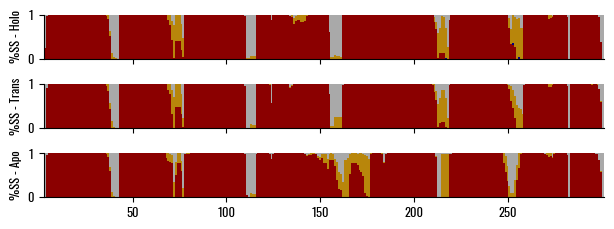

In [17]:
h_prob, e_prob, t_prob = [], [], []
ss_holo = np.loadtxt('../02-analysis/ss_holo.csv',delimiter=',',dtype=str)
h_prob.append(np.mean((ss_holo=='H')|(ss_holo=='G')|(ss_holo=='I'),axis=0))
e_prob.append(np.mean((ss_holo=='E')|((ss_holo=='B')),axis=0))
t_prob.append(np.mean(ss_holo=='T',axis=0))

ss_trans = np.loadtxt('../02-analysis/ss_trans.csv',delimiter=',',dtype=str)
h_prob.append(np.mean((ss_trans=='H')|(ss_trans=='G')|(ss_trans=='I'),axis=0))
e_prob.append(np.mean((ss_trans=='E')|((ss_trans=='B')),axis=0))
t_prob.append(np.mean(ss_trans=='T',axis=0))

ss_apo = np.loadtxt('../02-analysis/ss_apo.csv',delimiter=',',dtype=str)
h_prob.append(np.mean((ss_apo=='H')|(ss_apo=='G')|(ss_apo=='I'),axis=0))
e_prob.append(np.mean((ss_apo=='E')|((ss_apo=='B')),axis=0))
t_prob.append(np.mean(ss_apo=='T',axis=0))

fig,ax = plt.subplots(3,1,figsize=(16/2.54,6/2.54),sharex=True,sharey=True)
x = np.arange(len(h_prob[0]))
for i in range(3):
    ax[i].bar(x,h_prob[i],color='darkred',width=1)
    ax[i].bar(x,e_prob[i],bottom=h_prob[i],color='navy',width=1)
    ax[i].bar(x,t_prob[i],bottom=h_prob[i]+e_prob[i],color='darkgoldenrod',width=1)
    ax[i].bar(x,np.ones(len(x))-h_prob[i]-e_prob[i]-t_prob[i],bottom=h_prob[i]+e_prob[i]+t_prob[i],color='darkgrey',width=1)


ax[0].set_ylabel('p(SS) - Holo')
ax[1].set_ylabel('p(SS) - Trans')
ax[2].set_ylabel('p(SS) - Apo')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x[0]-0.5,x[-1]+0.5)
xt = np.arange(50,300,50)
ax[2].set_xticks(xt-3)
ax[2].set_xticklabels(xt)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Secondary_structure.png',dpi=600,facecolor='white')

# Volume

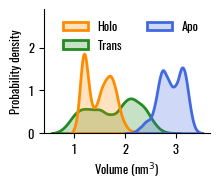

In [67]:
# Load volume data
vol_holo = np.loadtxt('../02-analysis/volume_holo.dat', usecols=1,skiprows=1)/1000
vol_apo = np.loadtxt('../02-analysis/volume_apo.dat', usecols=1,skiprows=1)/1000
vol_tran = np.loadtxt('../02-analysis/volume_trans.dat', usecols=1,skiprows=1)/1000

fig,ax = plt.subplots(1,1,figsize=(6/2.54,5/2.54))
sns.kdeplot(vol_holo,ax=ax,color=palette[1],label='Holo',cut=0, fill=True,zorder=1)
sns.kdeplot(vol_tran,ax=ax,color=palette[2],label='Trans',cut=0, fill=True,zorder=0)
sns.kdeplot(vol_apo,ax=ax,color=palette[0],label='Apo',cut=0, fill=True,zorder=1)
ax.set_xlabel('Volume (nm$^3$)')
ax.set_ylabel('Probability density')
ax.set_ylim(0,2.9)
ax.legend(ncol=2)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/Volume.png',dpi=600,facecolor='white')

# Angle 241

In [6]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')

# compute the angle of Y241
angles = []
for U in [u_apo,u_holo,u_trans]:
    angle = []
    for _ in U.trajectory:
        v1 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 241 and name CG CD2 CE2 CZ CE1 CD1').positions[0]
        v2 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 271 and name CA').positions[0]
        a1 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
        v2 = U.select_atoms('resid 241 and name CA').positions[0] - U.select_atoms('resid 188 and name CA').positions[0]
        a2 = np.arccos(np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))*180/np.pi
        angle.append([a1,a2])
    angles.append(np.vstack(angle))

angles = np.stack(angles,axis=0)

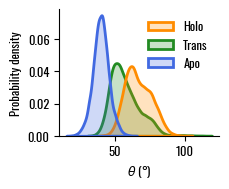

In [61]:
fig,ax = plt.subplots(1,1,figsize=(6/2.54,5/2.54),sharex=True,sharey=True)
sns.kdeplot(x=angles[1,:,0],ax=ax,color=palette[1],label='Holo',cut=0, fill=True,zorder=0)
sns.kdeplot(x=angles[2,:,0],ax=ax,color=palette[2],label='Trans',cut=0, fill=True,zorder=-1)
sns.kdeplot(x=angles[0,:,0],ax=ax,color=palette[0],label='Apo',cut=0, fill=True,zorder=0)
ax.legend()
ax.set_xlabel(r'$\theta$ (°)')
ax.set_ylabel('Probability density')
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/angle_Y241.png',dpi=600,facecolor='white')

# Stability of interactions between Strychnine and the receptor

In [9]:
def InteractionProbability(u,lig_chains,sel='protein',start=0,end=-1,step=1,nt=1):
    '''
    Function to compute the probabilitiy of specific interactions as identified by PLIP
    between each residue of a subset of atoms and any atom of the second subset.

    Reference
    Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA.
    Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
    
    Input
    ----------
    u:          MDAnalysis universe containing the input system.
    lig_chains: Chain of the subset of atoms to treat as ligand. It can also refer to protein atoms.
    sel:        Selection string for the subset of atoms to treat as receptor.
    start:      Starting time of analysis in ps. Default: 0
    end:        Last time of analysis in ps. Default: -1 (end of trajectory)
    step:       time step for the analysis. Default
    nt:         Number of cpus to use threshold in Angstrom to define the contact. Default 1

    Returns
    -------
    int_res:    Dataframe containing the information about interactions and related probabilities.
    '''

    # try the import of plip
    try:
        from plip.basic import config
        from plip.structure.preparation import PDBComplex
    except ImportError:
        print('To use the InteractionProbability function it is necessary to install plip in the environment.')
        print('Try using conda install -n [NAME ENV] -c conda-forge plip')
        exit(1)
    
    # initialization
    if (not step) & (type(step) == int):
        time_step = step
        step_frame = int(step/u.trajectory.dt)
    elif (not step) & (type(step) != int):
        print('Input time step in ps is expected as integer.')
        exit(1)
    else:
        time_step = u.trajectory.dt
        step_frame = 1
    
    start_frame = int(start/time_step)
    if end != -1:
        end_frame = int(end/time_step)
    else:
        end_frame = u.trajectory.n_frames
    tot_frames = end_frame - start_frame

    for ts in u.trajectory[start_frame:end_frame:step_frame]:
        selec = u.select_atoms(sel)
        selec.write('pippo.pdb')
        mymol = PDBComplex()
        mymol.load_pdb('pippo.pdb')
        # set the protein peptide chain
        config.PEPTIDES = lig_chains
        config.MAXTHREADS = nt
        mymol.analyze()
        tp = list()
        protc = list(); protn = list(); prott = list()
        ligc = list(); lign = list(); ligt = list()
        if ts.frame == start_frame:
            # for the first frame, initialize the dataframe of results
            for k in mymol.interaction_sets.keys():
                for interaction in mymol.interaction_sets[k].all_itypes:
                    tp.append(str(interaction).split("(")[0])
                    protc.append(interaction.reschain)
                    protn.append(interaction.resnr)
                    prott.append(interaction.restype)
                    ligc.append(interaction.reschain_l)
                    lign.append(interaction.resnr_l)
                    ligt.append(interaction.restype_l)
            int_res = pd.DataFrame({"Type":tp,
                                    "Chain_1":protc,"Name_1":prott,"Num_1":protn,
                                    "Chain_2":ligc,"Name_2":ligt,"Num_2":lign})
            int_res['probability'] = np.ones(int_res.shape[0])
            int_res = int_res.drop_duplicates(ignore_index=True)
            

        else:
            # here update the initialized dataframe
            for k in mymol.interaction_sets.keys():
                for interaction in mymol.interaction_sets[k].all_itypes:
                    tp.append(str(interaction).split("(")[0])
                    protc.append(interaction.reschain)
                    protn.append(interaction.resnr)
                    prott.append(interaction.restype)
                    ligc.append(interaction.reschain_l)
                    lign.append(interaction.resnr_l)
                    ligt.append(interaction.restype_l)
            provv = pd.DataFrame({"Type":tp,
                                  "Chain_1":protc,"Name_1":prott,"Num_1":protn,
                                  "Chain_2":ligc,"Name_2":ligt,"Num_2":lign})
            provv = provv.drop_duplicates(ignore_index=True)
            provv['probability'] = np.ones(provv.shape[0])
            for _,row in provv.iterrows():
                # search if the same interaction has been found previously
                tt = int_res[(int_res['Type'] == row['Type']) & \
                             (int_res['Chain_1'] == row['Chain_1']) & \
                             (int_res['Name_1'] == row['Name_1']) & \
                             (int_res['Num_1'] == row['Num_1']) & \
                             (int_res['Chain_2'] == row['Chain_2']) & \
                             (int_res['Name_2'] == row['Name_2']) & \
                             (int_res['Num_2'] == row['Num_2'])].index.tolist()
                if tt:
                    # if found increase the count
                    int_res.loc[tt,'probability'] += 1
                else:
                    # if not found add a new row
                    int_res = pd.concat([pd.DataFrame([row]), int_res], ignore_index=True)
        # cleaning
        os.remove('pippo.pdb')
        
    # divide for the number of frames to obtain the probability
    int_res['probability'] = int_res['probability']/tot_frames
    return int_res

In [17]:
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
interactions = InteractionProbability(u_holo,lig_chains=['B'],sel='byres (around 15 resname LIG) or resname LIG',start=0,end=-1,step=1,nt=1)
interactions.to_csv('../02-analysis/interactions_strychnine.csv',index=False)

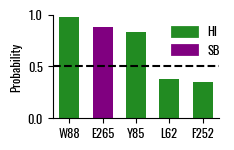

In [47]:
interactions.sort_values(by='probability',ascending=False,inplace=True)
resname_convert = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLN':'Q','GLU':'E','GLY':'G','HIS':'H',
                   'ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W',
                   'TYR':'Y','VAL':'V','HID':'H','HIE':'H','HIP':'H','CYX':'C','CYM':'C','ASH':'D','GLH':'E'}
colordef = {'hbond':'darkorange','hydroph_interaction':'forestgreen','saltbridge':'purple',
            'pistack':'royalblue','pication':'tomato'}
short_type = {'hbond':'HB','hydroph_interaction':'HI','saltbridge':'SB',
            'pistack':'PS','pication':'PC'}
          
xlab = [f'{resname_convert[row["Name_1"]]}{row["Num_1"]}' for _,row in interactions.iterrows()]
colors = [colordef[row['Type']] for _,row in interactions.iterrows()]

fig,ax = plt.subplots(1,1,figsize=(6/2.54,4/2.54))
N = 5
ax.bar(np.arange(N),interactions['probability'].values[:N],color=colors[:N],width=0.6)
ax.axhline(0.5,color='k',ls='--',lw=1.5)

# create legend for color associated to interaction type
int_to_show = np.unique(interactions['Type'].values[:N])
handles = [plt.Rectangle((0,0),1,1,color=colordef[i]) for i in int_to_show]
labels = [short_type[i] for i in int_to_show]
ax.legend(handles,labels,loc='upper left',bbox_to_anchor=(0.65,1),ncol=1)

ax.set_xticks(np.arange(N))
ax.set_xticklabels(xlab[:N])
ax.set_ylabel('Probability')
ax.set_ylim(0,1)
ax.set_yticks([0,0.5,1])
ax.set_xlim(-0.5,N-0.5)
sns.despine()
fig.tight_layout()
fig.savefig('../05-Images/interactions_strychnine.png',dpi=600,facecolor='white')

# Distance between ECL1 and ECL3

In [102]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps_fit.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')
ECL3 = "resid 253 to 259"
ECL1 = "resid 71  to 79"

distances = []
for U in [u_apo,u_holo,u_trans]:
    d = []
    for _ in U.trajectory:
        d.append(np.linalg.norm(U.select_atoms(ECL3).center_of_mass() - U.select_atoms(ECL1).center_of_mass(),2))
    distances.append(np.array(d))

distances = np.column_stack(distances)

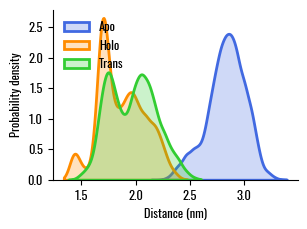

In [104]:
fig,ax = plt.subplots(1,1,figsize=(8/2.54,6/2.54))
sns.kdeplot(distances[:,0]/10,ax=ax,color=palette[0],label='Apo',cut=0, fill=True)
sns.kdeplot(distances[:,1]/10,ax=ax,color=palette[1],label='Holo',cut=0, fill=True)
sns.kdeplot(distances[:,2]/10,ax=ax,color=palette[2],label='Trans',cut=0, fill=True)
ax.set_xlabel('Distance (nm)')
ax.set_ylabel('Probability density')
ax.legend(loc='upper left')
sns.despine()
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


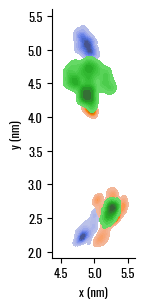

In [101]:
u_apo = mda.Universe('../01-sim/7XP4/start.pdb','../01-sim/7XP4/cat_50ps_fit.xtc')
u_holo = mda.Universe('../01-sim/7XP6/start.pdb','../01-sim/7XP6/cat_50ps.xtc')
u_trans = mda.Universe('../01-sim/7XP6_noLig/start.pdb','../01-sim/7XP6_noLig/cat_50ps.xtc')

fig,ax = plt.subplots(1,1,figsize=(8/2.54,8/2.54))
systems = ['Apo','Holo','Trans']
for i,U in enumerate([u_apo,u_holo,u_trans]):
    pos1,pos3 = [], []
    for _ in U.trajectory:
        pos1.append(U.select_atoms(ECL1).center_of_mass()/10)
        pos3.append(U.select_atoms(ECL3).center_of_mass()/10)
    pos1 = np.vstack(pos1)
    pos3 = np.vstack(pos3)
    sns.kdeplot(x=pos1[:,0],y=pos1[:,1],fill=True,color=palette[i],ax=ax,label=systems[i])
    sns.kdeplot(x=pos3[:,0],y=pos3[:,1],fill=True,color=palette[i],ax=ax)
ax.set_aspect('equal')
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.legend()
sns.despine()
fig.tight_layout()